# Coffee Daily Price Per Pound

# Libraries and Packages

In [72]:
import pandas as pd
import numpy as np
import seaborn as snb
import matplotlib as mpl
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import seaborn as sns

## Loading Dataset

In [63]:
coffee = pd.read_csv('/Users/galexiss/Documents/Education/Data Science/DSO110 - Final Group Project/Coffee Daily Price/coffee.csv', parse_dates=['Date'])
coffee.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5683 entries, 0 to 5682
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      5683 non-null   datetime64[ns]
 1   Open      5683 non-null   float64       
 2   High      5683 non-null   float64       
 3   Low       5683 non-null   float64       
 4   Close     5683 non-null   float64       
 5   Volume    5683 non-null   int64         
 6   Currency  5683 non-null   object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 310.9+ KB


## Data Wrangling

In [66]:
coffee.head()

,Date,Open,High,Low,Close,Volume,Currency,Year
0,2000-01-03,122.25,124.00,116.10,116.50,6640,USD,2000
1,2000-01-04,116.25,120.50,115.75,116.25,5492,USD,2000
2,2000-01-05,115.00,121.00,115.00,118.60,6165,USD,2000
3,2000-01-06,119.00,121.40,116.50,116.85,5094,USD,2000
4,2000-01-07,117.25,117.75,113.80,114.15,6855,USD,2000


### Coffee by year

In [65]:
coffee['Year'] = pd.DatetimeIndex(coffee['Date']).year

In [70]:
coffee_mean = coffee.groupby(['Year']).mean()
coffee_mean

,Open,High,Low,Close,Volume
Year,,,,,
2000,89.698000,91.102800,88.619200,89.606600,3644.852000
2001,54.867418,55.786475,54.261270,54.927459,3484.610656
2002,53.158434,54.163855,52.571285,53.379317,3938.329317
2003,61.760040,62.665462,61.180924,61.883735,4874.000000
2004,75.765060,76.977912,74.979920,76.023092,7247.244980
2005,107.065538,108.808167,106.002590,107.269124,6521.824701
2006,107.515800,108.961600,106.559200,107.699000,7370.012000
2007,117.161044,118.339759,116.172490,117.292369,7774.582329
2008,132.266206,133.924111,130.371344,131.976087,7826.853755


In [81]:
coffee_mean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23 entries, 2000 to 2022
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    23 non-null     float64
 1   High    23 non-null     float64
 2   Low     23 non-null     float64
 3   Close   23 non-null     float64
 4   Volume  23 non-null     float64
dtypes: float64(5)
memory usage: 1.1 KB


AttributeError: 'Int64Index' object has no attribute 'year'

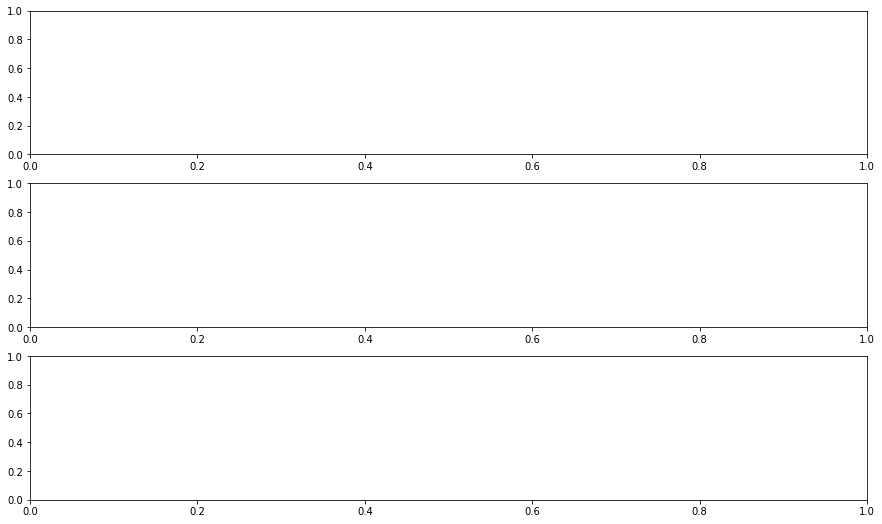

In [83]:
fig, axes = plt.subplots(3, 1, figsize=(15, 9))

idx = pd.MultiIndex.from_arrays([
        coffee_mean.index.year
    ])

d1 = coffee_mean.set_index(idx).unstack().resample('Close').mean()
d1.Open.plot(ax=axes[0], title='Open')
lg = axes[0].legend(bbox_to_anchor=(1.02, 1), loc=2, ncol=1)

d1.Close.plot(ax=axes[1], title='Close', legend=False)
d1.High.plot(ax=axes[2], title='High', legend=False)
d1.Low.plot(ax=axes[3], title='Low', legend=False)

fig.tight_layout()